## Generate training data

In [1]:
import numpy as np
from cobra.io import load_model
import matplotlib.pyplot as plt
import FBA_data_generation
import plotting

In [2]:
model = load_model("textbook")
# model = load_model("iJO1366")
vman = "PYK"
file_path = f"data/fba_data_{vman}_aerobic.npz"

In [3]:
rxn = model.reactions.get_by_id(vman)
print(rxn)

PYK: adp_c + h_c + pep_c --> atp_c + pyr_c


In [4]:
# anaerobic conditions
# upper bound glucose uptake: 10 mmol/g/h

medium = model.medium
medium["EX_o2_e"] = 0.0
model.medium = medium

file_path = f"data/fba_data_{vman}_anaerobic.npz"

model.medium

{'EX_co2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_pi_e': 1000.0}

In [5]:
# 1) inspect current ACKr bounds and baseline solution
rxn = model.reactions.get_by_id("ACKr")
print("ACKr reaction:", rxn.reaction)
print("Original bounds:", rxn.lower_bound, rxn.upper_bound)

sol = model.optimize()
print("Baseline ACKr flux in current solution:", sol.fluxes.get("ACKr"))

# 2) store original bounds so you can restore later
orig_bounds = (rxn.lower_bound, rxn.upper_bound)

# 3) relax bounds (example: allow -20 .. 20)
rxn.bounds = (-20.0, 20.0)
print("New ACKr bounds:", rxn.bounds)

# 4) quick feasibility check at a few values
test_vals = np.linspace(-10, 10, 21)
feasible = []
for v in test_vals:
    rxn.bounds = (v, v)
    s = model.optimize()
    feasible.append((v, s.status))
print("Quick feasibility check (v, status, obj):")
for t in feasible:
    print(t)

# 5) restore original bounds when done
rxn.bounds = orig_bounds
print("Bounds restored to:", rxn.bounds)


ACKr reaction: ac_c + atp_c <=> actp_c + adp_c
Original bounds: -1000.0 1000.0
Baseline ACKr flux in current solution: -8.503585277961259
New ACKr bounds: (-20.0, 20.0)
Quick feasibility check (v, status, obj):
(np.float64(-10.0), 'optimal')
(np.float64(-9.0), 'optimal')
(np.float64(-8.0), 'optimal')
(np.float64(-7.0), 'optimal')
(np.float64(-6.0), 'optimal')
(np.float64(-5.0), 'optimal')
(np.float64(-4.0), 'optimal')
(np.float64(-3.0), 'optimal')
(np.float64(-2.0), 'optimal')
(np.float64(-1.0), 'optimal')
(np.float64(0.0), 'optimal')
(np.float64(1.0), 'infeasible')
(np.float64(2.0), 'infeasible')
(np.float64(3.0), 'infeasible')
(np.float64(4.0), 'infeasible')
(np.float64(5.0), 'infeasible')
(np.float64(6.0), 'infeasible')
(np.float64(7.0), 'infeasible')
(np.float64(8.0), 'infeasible')
(np.float64(9.0), 'infeasible')
(np.float64(10.0), 'infeasible')
Bounds restored to: (-1000.0, 1000.0)


/Users/Pineapplethefruitdude/Documents/Uni/Uni Köln/Master Project/Code/vincent_code/.venv/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [6]:
# generate new FBA data
X, Y, feasible_range = FBA_data_generation.generate_fba_data(model, vman, file_path)

Feasible region for PYK: [0.00, 25.13]


In [7]:
print(len(X))
print(len(Y))

1000
1000


In [8]:
# load existing FBA data
data = np.load(file_path, allow_pickle=True)

X = data["X"]
Y = data["Y"]
feasible_range = data["feasible_range"]  # unpack from object dtype

In [9]:
print(feasible_range)

[ 0.         25.12562814]


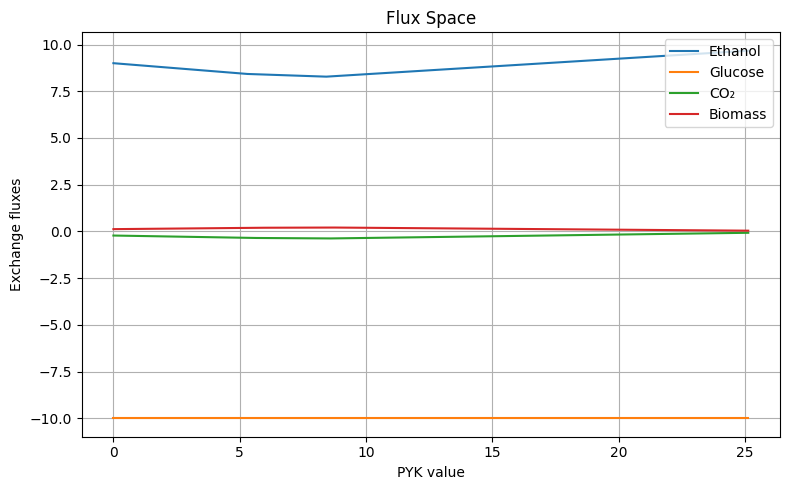

In [10]:
plotting.plot_flux_space(
    X, Y,
    vman_id=vman,
    output_labels=["Ethanol", "Glucose", "CO₂", "Biomass"]
)

## Train Surrogate in PyTorch

In [11]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import surrogateNN

In [12]:
x_scaler, y_scaler, X_train, Y_train, X_val, Y_val, X_test, Y_test = surrogateNN.ML_data_prep(X, Y)
neurons = 4

model_nn = surrogateNN.SurrogateNN(
    input_dim=X_train.shape[1],
    output_dim=Y_train.shape[1],
    hidden_dim=neurons
)

loss_fn=nn.MSELoss()

In [13]:
print(Y.shape)


(1000, 4)


In [14]:
model_nn, train_losses, val_losses = surrogateNN.train_model(
    model_nn, X_train, Y_train, X_val, Y_val,
    loss_fn=loss_fn, epochs=10000, patience=50
)

Epoch 000 | Train Loss: 0.9240 | Val Loss: 0.8972
Epoch 100 | Train Loss: 0.7105 | Val Loss: 0.6907
Epoch 200 | Train Loss: 0.5710 | Val Loss: 0.5617
Epoch 300 | Train Loss: 0.4486 | Val Loss: 0.4502
Epoch 400 | Train Loss: 0.3341 | Val Loss: 0.3422
Epoch 500 | Train Loss: 0.2475 | Val Loss: 0.2584
Epoch 600 | Train Loss: 0.1859 | Val Loss: 0.1966
Epoch 700 | Train Loss: 0.1423 | Val Loss: 0.1527
Epoch 800 | Train Loss: 0.1113 | Val Loss: 0.1203
Epoch 900 | Train Loss: 0.0892 | Val Loss: 0.0964
Epoch 1000 | Train Loss: 0.0726 | Val Loss: 0.0783
Epoch 1100 | Train Loss: 0.0592 | Val Loss: 0.0636
Epoch 1200 | Train Loss: 0.0477 | Val Loss: 0.0511
Epoch 1300 | Train Loss: 0.0378 | Val Loss: 0.0402
Epoch 1400 | Train Loss: 0.0299 | Val Loss: 0.0316
Epoch 1500 | Train Loss: 0.0240 | Val Loss: 0.0250
Epoch 1600 | Train Loss: 0.0191 | Val Loss: 0.0198
Epoch 1700 | Train Loss: 0.0152 | Val Loss: 0.0156
Epoch 1800 | Train Loss: 0.0120 | Val Loss: 0.0122
Epoch 1900 | Train Loss: 0.0094 | Val Los

In [15]:
from pathlib import Path
import torch

# Define base directory for models
MODEL_DIR = Path("trained_models")
MODEL_DIR.mkdir(exist_ok=True)  # create folder if it doesn't exist

# Construct consistent filename
model_filename = f"{vman}_trained_model_input-{X_train.shape[1]}_output-{Y_train.shape[1]}_hidden-{neurons}.pt"
model_path = MODEL_DIR / model_filename

# --- Save model ---
torch.save(model_nn.state_dict(), model_path)

In [16]:
# Rebuild the model architecture (must match original)
model_nn = surrogateNN.SurrogateNN(input_dim=1, hidden_dim=4, output_dim=4)

# Load weights
model_nn.load_state_dict(torch.load(model_path, map_location="cpu"))
model_nn.eval()  # important for inference


SurrogateNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [17]:
# save full model
#torch.save({
#    "model_state": model_nn.state_dict(),
#    "optimizer_state": optimizer.state_dict(),
#    "epoch": epoch,
#    "train_losses": train_losses,
#}, "checkpoint.pth")

#checkpoint = torch.load("checkpoint.pth")
#model_nn.load_state_dict(checkpoint["model_state"])
#optimizer.load_state_dict(checkpoint["optimizer_state"])

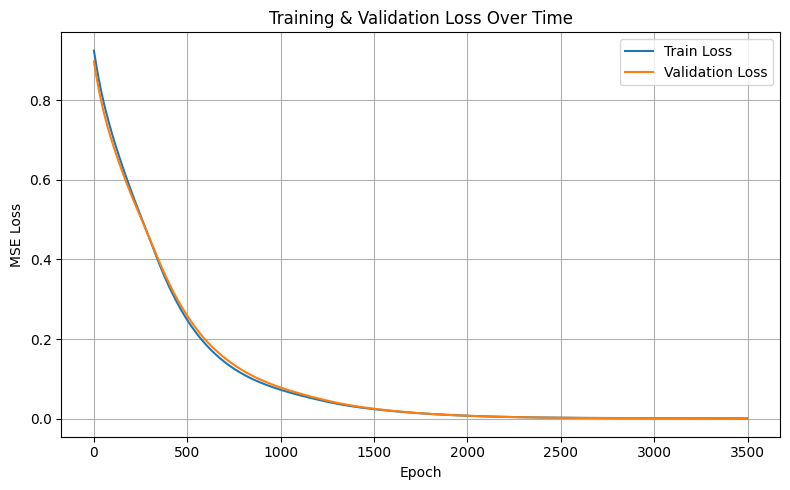

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
model_nn.eval()
with torch.no_grad():
    pred_test = model_nn(X_test)
    loss_test = loss_fn(pred_test, Y_test)

print(f"Final Test MSE: {loss_test.item():.4f}")


Final Test MSE: 0.0011


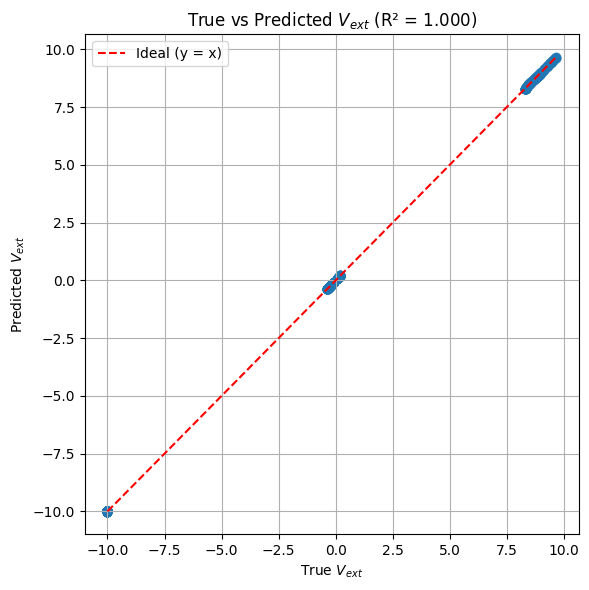

In [20]:
Y_test_np = Y_test.numpy()
pred_test_np = pred_test.numpy()

# Undo scaling
Y_test_true = y_scaler.inverse_transform(Y_test_np)
pred_test_true = y_scaler.inverse_transform(pred_test_np)

# Flatten to plot across all outputs
Y_true_flat = Y_test_true.flatten()
Y_pred_flat = pred_test_true.flatten()

# R² score
r2 = r2_score(Y_true_flat, Y_pred_flat)

# Scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(Y_true_flat, Y_pred_flat, alpha=0.6)
plt.plot([Y_true_flat.min(), Y_true_flat.max()],
         [Y_true_flat.min(), Y_true_flat.max()],
         'r--', label="Ideal (y = x)")
plt.xlabel("True $V_{ext}$")
plt.ylabel("Predicted $V_{ext}$")
plt.title(f"True vs Predicted $V_{{ext}}$ (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
print(Y_test_true.shape)
print(Y_true_flat.shape)


(200, 4)
(800,)


## Build the Hybrid Model

In [22]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import hybrid_model

2.3.4


In [23]:
def vman_func(t):
    return 5.0  # constant PFK flux
    # return 5.0 + 2.0 * np.sin(0.5 * t)  # sinusoidal control

In [24]:
# initial state: [glucose, ethanol, biomass]
z0 = [10.0, 0.0, 0.01]
tspan = (0, 20)
t_eval = np.linspace(tspan[0], tspan[1], 20)

sol = solve_ivp(
    fun=lambda t, z: hybrid_model.hybrid_ode(t, z, vman_func, model_nn, x_scaler, y_scaler),
    t_span=tspan,
    y0=z0,
    t_eval=t_eval,
    method='RK45'
)

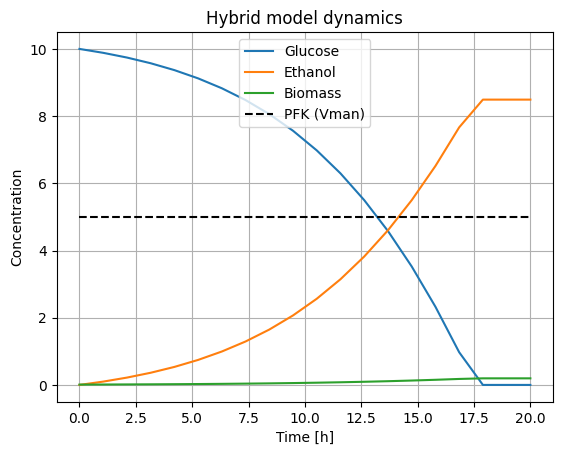

In [25]:
plt.clf()

plt.plot(sol.t, sol.y[0], label='Glucose')
plt.plot(sol.t, sol.y[1], label='Ethanol')
plt.plot(sol.t, sol.y[2], label='Biomass')
vman_values = [vman_func(t) for t in sol.t]
plt.plot(sol.t, vman_values, label='PFK (Vman)', linestyle='--', color='black')
plt.xlabel("Time [h]")
plt.ylabel("Concentration")
plt.title("Hybrid model dynamics")
plt.legend()
plt.grid(True)
plt.show()

## Vman Optimization - doesn't work yet

In [ ]:
from optim import optimize_vman
from hybrid_model import hybrid_ode

#define the setup

z0 = [10.0, 0.0, 0.01] # initial state: [glucose, ethanol, biomass]
t_span = (0, 12)
t_eval_points = np.linspace(0, 12, 200)
N = 4
lower, upper = feasible_range
bounds = [(lower, upper)] * N


result, logs = optimize_vman(
    model = model_nn,
    hybrid_ode=hybrid_ode,
    z0=z0,
    t_span=t_span,
    N=N,
    t_eval_points=t_eval_points,
    bounds=bounds,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    log_trajectories=True
)

in cost, should enter obj_fn now
in obj_fn!
biomass: 0.0431698329957991
in cost, should enter obj_fn now
in obj_fn!
biomass: 0.0431698329957991
in cost, should enter obj_fn now
in obj_fn!
biomass: 0.0431698329957991
in cost, should enter obj_fn now
in obj_fn!
biomass: 0.0431698329957991
in cost, should enter obj_fn now
in obj_fn!
biomass: 0.0431698329957991


In [27]:
opt_vman_values = result.x  # optimized control nodes

# Recreate the same time structure used in the optimizer
control_times = np.linspace(t_span[0], t_span[1], N+1)

# Define the time-dependent control function again
def vman_t_opt(t):
    idx = np.searchsorted(control_times, t, side='right') - 1
    idx = np.clip(idx, 0, N - 1)
    return opt_vman_values[idx]

# Re-run the hybrid ODE with optimized control
sol_opt = solve_ivp(
    fun=lambda t, z: hybrid_ode(t, z, vman_t_opt, model_nn, x_scaler, y_scaler),
    t_span=t_span,
    y0=z0,
    t_eval=t_eval_points,
    method='RK45'
)


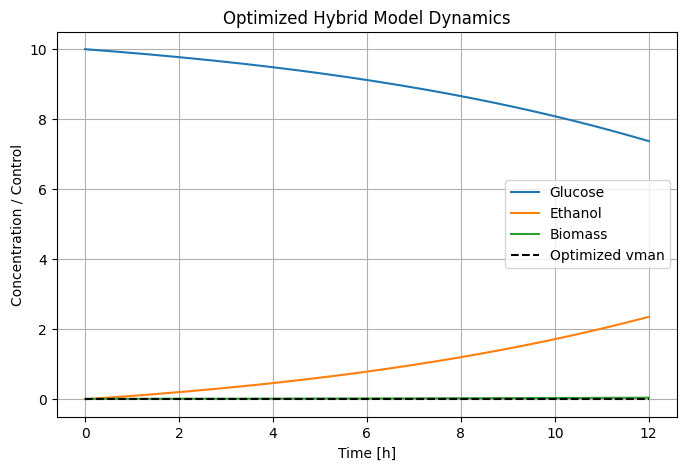

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(sol_opt.t, sol_opt.y[0], label='Glucose')
plt.plot(sol_opt.t, sol_opt.y[1], label='Ethanol')
plt.plot(sol_opt.t, sol_opt.y[2], label='Biomass')

# plot control trajectory
vman_values = [vman_t_opt(t) for t in sol_opt.t]
plt.plot(sol_opt.t, vman_values, '--k', label='Optimized vman')

plt.xlabel('Time [h]')
plt.ylabel('Concentration / Control')
plt.title('Optimized Hybrid Model Dynamics')
plt.legend()
plt.grid(True)
plt.show()
